`Problem Description` : <br> 
we are going to do speech recognition using Hidden Markov Model <br> we want to train two models; one for the speaker of recorded voice and one for the number of recorded voice

In [6]:
from scipy.io import wavfile as wav
import numpy as np
import os as os
import matplotlib.pyplot as  plt 
import librosa as lb
import random as rd
import python_speech_features
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pylab as pl
from sklearn.metrics import ConfusionMatrixDisplay

# model for recognizing numbers : 

## Pre_processing

##### we reed all the voices in recordings folder then all elements of signal has been shifted by the min of the signal and has been divided by max of signal and the zero elements has been removed

In [7]:
DATA_FOLDER = "./recordings"
OUTPUT_FOLDER = "improved_data/"
data_list = os.listdir(DATA_FOLDER)
for name in data_list:
    sample_rate  , data = wav.read(DATA_FOLDER + "/" + name)
    new_data = data
    new_data = new_data - np.min(new_data)
    new_data = data.astype(float) / np.max(data)
    new_data = new_data[new_data!= 0]
    wav.write(OUTPUT_FOLDER + name,sample_rate,new_data)

##### First The data has been reed and passed the data through a high pass filter to amplitude high frequency parts of the speech (Pre-emphasis). 
##### Then a dictionary from the data will be made. 

In [8]:
DATA_FOLDER = "improved_data/"
data_list = os.listdir(DATA_FOLDER)
mfccs_dictionary = {}
for i in range(10):
    mfccs_dictionary[i] = []
shape_list = []
for name in data_list:
    sample_rate , data = wav.read(DATA_FOLDER + "/" + name)
    data=lb.effects.preemphasis(data.astype(float),coef= 0.9, return_zf= False)
    mfcc = python_speech_features.mfcc(data , sample_rate , nfft= 551)
    shape_list.append(mfcc.shape)
    mfccs_dictionary[int(name[0])].append(mfcc)

### Plotting MFCCs 
##### in this part randomly one of each parts was being chosen then it been plotted 

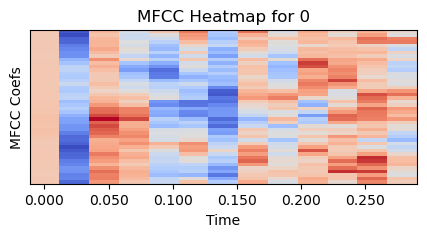

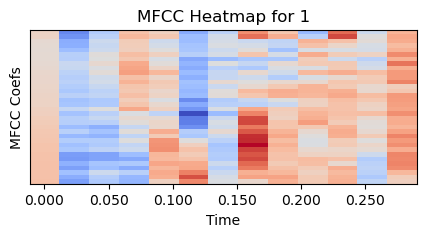

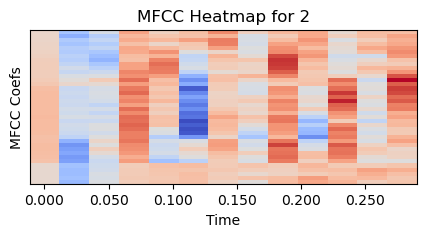

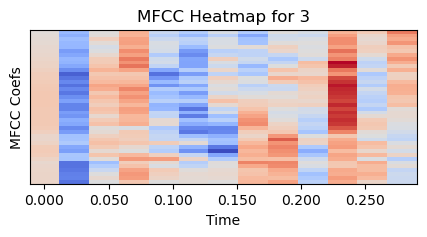

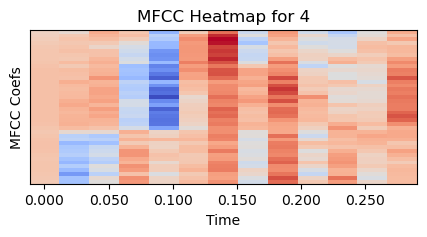

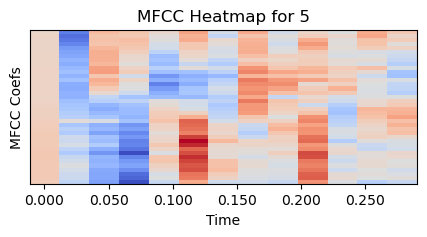

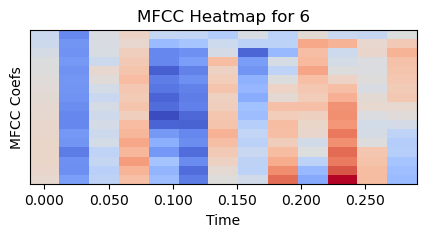

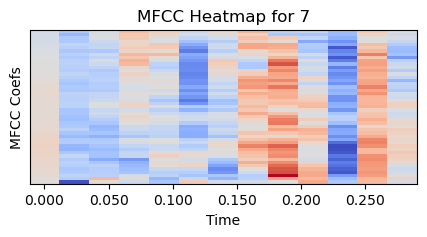

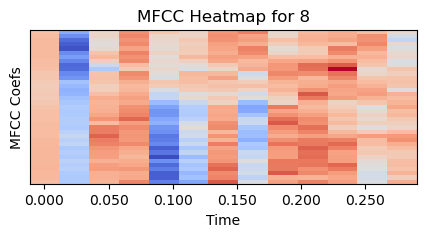

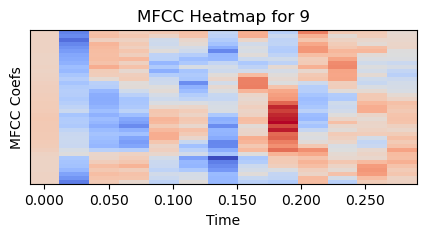

In [9]:
for i in range(10):
    mfcc_to_show  = rd.choice(mfccs_dictionary[i])
    plt.figure(figsize=(5, 2))
    lb.display.specshow(mfcc_to_show, x_axis='time')
    plt.title("MFCC Heatmap for {}".format(i))
    plt.ylabel('MFCC Coefs')
    plt.show()
     

### Make MFCCs with same length
#### this section choose last 13 elements of each MFCC

In [10]:
def cut_mfcc(min_len,mfcc):
    return mfcc[: , -min_len: ]
min_len_dict={}
for i in range(10):
    min_len = min(mfccs_dictionary[i], key= lambda x : x.shape).shape
    min_len_dict[i]= min_len[1]
min_len = min(min_len_dict.values())
for i in range(10):
    for j in range(len(mfccs_dictionary[i])):
        mfccs_dictionary[i][j] = cut_mfcc(min_len,mfccs_dictionary[i][j] )

## Implement Using Library

### Split test and train data and Train model
#### in this part we choose 80% of data to train model and store the rest to test.
#### for every number a model has been made. 

In [11]:
from hmmlearn import  hmm

In [12]:
hmm_models = []
TRAIN_PERCENT = 80
test_index = {}
TEST_PERCENT = 100-TRAIN_PERCENT
def get_train_test(list):
    test_num = int(len(list) * TEST_PERCENT / 100)
    test = rd.sample(range(len(list)), test_num)
    train = np.setdiff1d([i for i in range(len(list))], test)
    return train, test
for i in range(10):
    model_i= hmm.GaussianHMM(n_components=10, covariance_type='diag')
    train , test = get_train_test(mfccs_dictionary[i])
    test_index[i] = test 
    x = np.concatenate([mfccs_dictionary[i][j] for j in train])
    model_i.fit(x)
    hmm_models.append(model_i)

### Testing model 
#### The maximum score of each test data has been calculated.

In [13]:
def test_model(model_list,test_data):
    digit = None
    max_score = -np.inf
    for i in range(10):
        curr_score = model_list[i].score(test_data)
        if( curr_score > max_score ): 
            max_score = curr_score
            digit = i
    return digit
class Test_result: 
    def __init__(self, actual_value , test_result):
        self.actual_value = actual_value
        self.test_result = test_result
test_list = []
recall  ={}

##### In this section each test result has been stored using Test_result class so it is possible to calculate precision, f1, and recall 

In [14]:
for i in range(10):
    score = 0 
    for j in test_index[i]:
        predicted_digit = test_model(hmm_models , mfccs_dictionary[i][j])
        test_list.append(Test_result(i, predicted_digit))
        if(predicted_digit == i):
            score +=1
    recall[i] = score/len(test_index[i])

### Qualification of Model 
#### The recall, f1, and precision has been calculated and printed.

In [15]:
precision= {}
def calculate_precision(test_result,digit):
    digit_result = list(filter(lambda x : x.test_result == digit, test_result))
    digit_true_result = list(filter(lambda x : x.test_result == digit and x.test_result == x.actual_value, test_result))
    if(len(digit_result)== 0 ):
        return 0
    return len(digit_true_result)/len(digit_result)
def calculate_recall(test_result,digit):
    digit_data = list(filter(lambda x : x.actual_value == digit, test_result))
    digit_true_result = list(filter(lambda x : x.test_result == digit and x.test_result == x.actual_value, test_result))
    return len(digit_true_result)/len(digit_data)
def calculate_f1(i):
    return 2 * (recall[i] * precision[i]) / (recall[i] + precision[i])

In [16]:
print("Accuracy is: {}".format(sum([x for x in recall.values()])/10))
for i in range(10):
    print("Recall for {} is: {}".format(i, recall[i]))
for i in range(10):
    precision[i] = calculate_precision(test_list , i)
    print("Precision for {} is : {}".format(i , precision[i]))
for i in range(10):
    print("F1 score for {} is : {}".format(i , calculate_f1(i)))

Accuracy is: 0.9116666666666667
Recall for 0 is: 0.95
Recall for 1 is: 0.8666666666666667
Recall for 2 is: 0.9833333333333333
Recall for 3 is: 0.8
Recall for 4 is: 1.0
Recall for 5 is: 1.0
Recall for 6 is: 0.7333333333333333
Recall for 7 is: 0.8166666666666667
Recall for 8 is: 0.9833333333333333
Recall for 9 is: 0.9833333333333333
Precision for 0 is : 1.0
Precision for 1 is : 0.9629629629629629
Precision for 2 is : 0.8194444444444444
Precision for 3 is : 0.9795918367346939
Precision for 4 is : 1.0
Precision for 5 is : 0.8108108108108109
Precision for 6 is : 0.88
Precision for 7 is : 1.0
Precision for 8 is : 0.7866666666666666
Precision for 9 is : 0.9833333333333333
F1 score for 0 is : 0.9743589743589743
F1 score for 1 is : 0.912280701754386
F1 score for 2 is : 0.893939393939394
F1 score for 3 is : 0.8807339449541285
F1 score for 4 is : 1.0
F1 score for 5 is : 0.8955223880597014
F1 score for 6 is : 0.8
F1 score for 7 is : 0.8990825688073394
F1 score for 8 is : 0.8740740740740739
F1 scor

#### Calculate and Draw Confusion Matrix

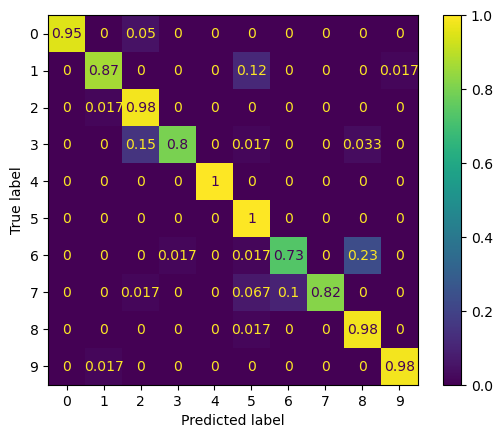

In [17]:
numbers= [str(x ) for x in range(10)]
def calculate_confusion_matrix(test_result_list):
    matrix = [[0 for i in range(10) ] for i in range(10)]
    for i in range(10):
        for j in range(10):
           matrix[i][j]=  sum([1 for x in test_result_list if x.actual_value == i and x.test_result==j])/len(test_index[i])
    return matrix

ConfusionMatrixDisplay(np.array(calculate_confusion_matrix(test_list)), display_labels=numbers).plot()
plt.show()

## From Scratch

In [18]:
from scipy.stats import multivariate_normal

### HMM Class
#### This class has been completed in the way to be a good Hidden Markov Model :)

In [19]:
class HMM:
    def __init__(self, num_hidden_states):
        self.num_hidden_states = num_hidden_states
        self.rand_state = np.random.RandomState(1)

        self.initial_prob = self._normalize(self.rand_state.rand(self.num_hidden_states, 1))
        self.transition_matrix = self._stochasticize(self.rand_state.rand(self.num_hidden_states, self.num_hidden_states))

        self.mean = None
        self.covariances = None
        self.num_dimensions = None

    def _forward(self, observation_matrix):
        log_likelihood = 0.
        T = observation_matrix.shape[1]
        alpha = np.zeros(observation_matrix.shape)

        for t in range(T):
            if t == 0:
                alpha[:, t] = observation_matrix[:,0] * self.initial_prob[:,0]
            else:
                alpha[:, t] = np.matmul(self.transition_matrix.T,alpha[:,t-1]) * observation_matrix[:,t]


            alpha_sum = np.sum(alpha[:, t])
            alpha[:, t] /= alpha_sum
            log_likelihood += np.log(alpha_sum)

        return log_likelihood, alpha

    def _backward(self, observation_matrix):
        T = observation_matrix.shape[1]
        beta = np.zeros(observation_matrix.shape)

        beta[:, -1] = np.ones(observation_matrix.shape[0])

        for t in range(T - 1)[::-1]:
            beta[:, t] = np.matmul(self.transition_matrix,(observation_matrix[:,t+1] * beta[:,t+1]))
            beta[:, t] /= np.sum(beta[:, t])

        return beta

    def _state_likelihood(self, obs):
        obs = np.atleast_2d(obs)
        B = np.zeros((self.num_hidden_states, obs.shape[1]))

        for s in range(self.num_hidden_states):
            np.random.seed(self.rand_state.randint(1))
            B[s, :] = multivariate_normal.pdf(obs.T , mean= self.mean[:,s],cov = self.covariances[:,:,s])
        return B

    def _normalize(self, x):
        return (x + (x == 0)) / np.sum(x)

    def _stochasticize(self, x):
        return (x + (x == 0)) / np.sum(x, axis=1)

    def _em_init(self, obs):
        if self.num_dimensions is None:
            self.num_dimensions = obs.shape[0]
        if self.mean is None:
            subset = self.rand_state.choice(np.arange(self.num_dimensions), size=self.num_hidden_states, replace=False)
            self.mean = obs[:, subset]
        if self.covariances is None:
            self.covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
            self.covariances += np.diag(np.diag(np.cov(obs)))[:, :, None]

        return self

    def _em_step(self, obs):
        obs = np.atleast_2d(obs)
        T = obs.shape[1]

        B = self._state_likelihood(obs)

        log_likelihood, alpha = self._forward(B)
        beta = self._backward(B)

        xi_sum = np.zeros((self.num_hidden_states, self.num_hidden_states))
        gamma = np.zeros((self.num_hidden_states, T))

        for t in range(T - 1):
            partial_sum = np.matmul(alpha[:,t],(beta[:,t+1].T*B[:,t+1].T))*self.transition_matrix
            xi_sum += self._normalize(partial_sum)
            partial_g = alpha[:,t] * beta[:,t]
            gamma[:, t] = self._normalize(partial_g)
        partial_g = alpha[:,T-1] * beta[:,T-1]
        gamma[:, -1] = self._normalize(partial_g)

        expected_prior = np.reshape(gamma[:,0], (-1,1))
        expected_transition = self._stochasticize(xi_sum/np.sum(xi_sum , axis = (0,1)))

        expected_covariances = np.zeros((self.num_dimensions, self.num_dimensions, self.num_hidden_states))
        expected_covariances += .01 * np.eye(self.num_dimensions)[:, :, None]

        gamma_state_sum = np.sum(gamma, axis=1)
        gamma_state_sum = gamma_state_sum + (gamma_state_sum == 0)

        expected_mean = np.zeros((self.num_dimensions, self.num_hidden_states))
        for s in range(self.num_hidden_states):
            gamma_obs = obs * gamma[s, :]
            expected_mean[:, s] = np.sum(gamma_obs, axis=1) / gamma_state_sum[s]

        self.initial_prob = expected_prior
        self.mean = expected_mean
        self.covariances = expected_covariances
        self.transition_matrix = expected_transition

        return log_likelihood

    def train(self, obs, num_iterations=1):
        for i in range(num_iterations):
            self._em_init(obs)
            self._em_step(obs)
        return self

    def score(self, obs):
        B = self._state_likelihood(obs)
        log_likelihood, _ = self._forward(B)
        return log_likelihood

### Train
#### becaus danger of division by zero all element in data has been divided by max of that list

In [20]:
hmm_models = []
for i in range(10): 
    new_hmm_model = HMM(10)
    train , test = get_train_test(mfccs_dictionary[i])
    test_index[i] = test 
    x = np.concatenate([mfccs_dictionary[i][j] for j in train])
    new_hmm_model.train(x.T/np.amax(x.T) , 2)
    hmm_models.append(new_hmm_model)
    

### Test 

In [21]:
test_list = []
def test_model2(model_list,test_data):
    digit = None
    max_score = -np.inf
    for i in range(10):
        curr_score = model_list[i].score(test_data.T/np.amax(test_data.T))
        if( curr_score > max_score ): 
            max_score = curr_score
            digit = i
    return digit
for i in range(10): 
    score = 0 
    for j in test_index[i]:
        predicted_digit = test_model2(hmm_models , mfccs_dictionary[i][j])
        test_list.append(Test_result(i, predicted_digit))
        if(predicted_digit == i):
            score +=1
    recall[i] = score/len(test_index[i])

/tmp/ipykernel_3711/3490064586.py:26: RuntimeWarning: invalid value encountered in divide
  alpha[:, t] /= alpha_sum
/tmp/ipykernel_3711/3490064586.py:27: RuntimeWarning: divide by zero encountered in log
  log_likelihood += np.log(alpha_sum)


### Qualification

In [22]:
print("Accuracy is: {}".format(sum([x for x in recall.values()])/10))
for i in range(10):
    print("Recall for {} is: {}".format(i, recall[i]))
for i in range(10):
    precision[i] = calculate_precision(test_list , i)
    print("Precision for {} is : {}".format(i , precision[i]))
for i in range(10):
    print("F1 score for {} is : {}".format(i , calculate_f1(i)))

Accuracy is: 0.8333333333333334
Recall for 0 is: 0.9
Recall for 1 is: 0.8666666666666667
Recall for 2 is: 0.95
Recall for 3 is: 0.7166666666666667
Recall for 4 is: 0.8666666666666667
Recall for 5 is: 0.8666666666666667
Recall for 6 is: 0.9
Recall for 7 is: 0.7666666666666667
Recall for 8 is: 0.7333333333333333
Recall for 9 is: 0.7666666666666667
Precision for 0 is : 0.9310344827586207
Precision for 1 is : 0.896551724137931
Precision for 2 is : 0.7702702702702703
Precision for 3 is : 0.7413793103448276
Precision for 4 is : 0.9629629629629629
Precision for 5 is : 0.9454545454545454
Precision for 6 is : 0.627906976744186
Precision for 7 is : 0.8518518518518519
Precision for 8 is : 0.8301886792452831
Precision for 9 is : 0.92
F1 score for 0 is : 0.9152542372881356
F1 score for 1 is : 0.8813559322033899
F1 score for 2 is : 0.8507462686567164
F1 score for 3 is : 0.728813559322034
F1 score for 4 is : 0.912280701754386
F1 score for 5 is : 0.9043478260869566
F1 score for 6 is : 0.73972602739726

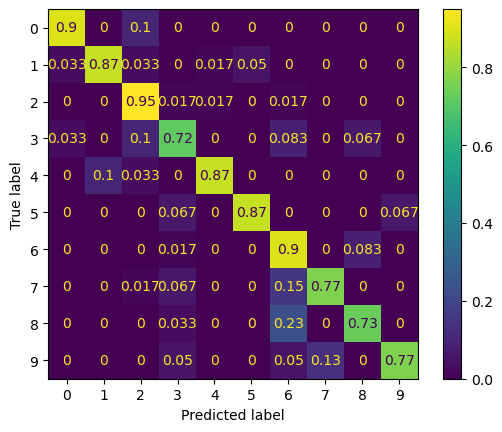

In [23]:
numbers= [str(x ) for x in range(10)]
def calculate_confusion_matrix(test_result_list):
    matrix = [[0 for i in range(10) ] for i in range(10)]
    for i in range(10):
        for j in range(10):
           matrix[i][j]=  sum([1 for x in test_result_list if x.actual_value == i and x.test_result==j])/len(test_index[i])
    return matrix
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay(np.array(calculate_confusion_matrix(test_list)), display_labels=numbers).plot()
plt.show()

# Model For Speaker
###### lets do all the useless things again

In [105]:
DATA_FOLDER = "./recordings"
OUTPUT_FOLDER = "improved_data/"
data_list = os.listdir(DATA_FOLDER)
for name in data_list:
    sample_rate  , data = wav.read(DATA_FOLDER + "/" + name)
    new_data = data
    new_data = new_data - np.min(new_data)
    new_data = data.astype(float) / np.max(data)
    new_data = new_data[new_data!= 0]
    wav.write(OUTPUT_FOLDER + name,sample_rate,new_data)

In [141]:
DATA_FOLDER = "improved_data/"
data_list = os.listdir(DATA_FOLDER)
mfccs_dictionary = {}
shape_list = []
for name in data_list:
    sample_rate , data = wav.read(DATA_FOLDER + "/" + name)
    # data=lb.effects.deemphasis(data.astype(float),coef= 0.5, return_zf= False)
    mfcc = python_speech_features.mfcc(data , sample_rate , nfft= 551)
    shape_list.append(mfcc.shape)
    splitted_name = name.split('_')
    
    if (splitted_name[1] in mfccs_dictionary.keys() ): 
        mfccs_dictionary[splitted_name[1]].append(mfcc)
    else : 
        mfccs_dictionary[splitted_name[1]] = [mfcc]
        

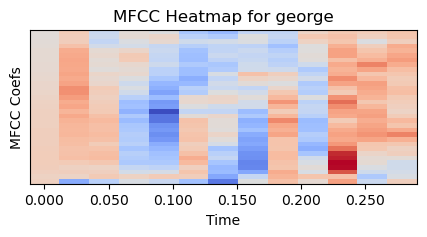

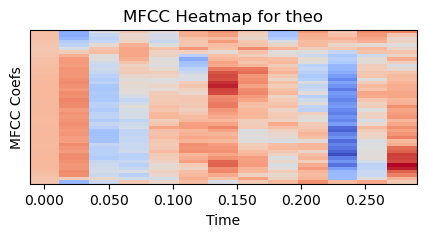

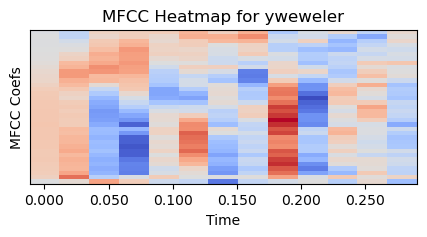

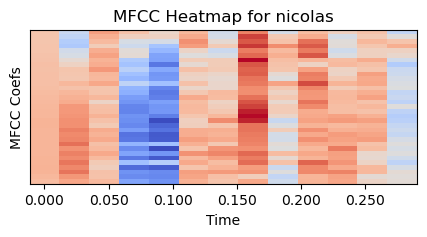

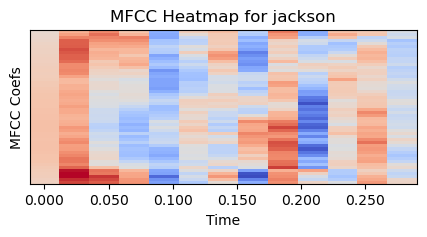

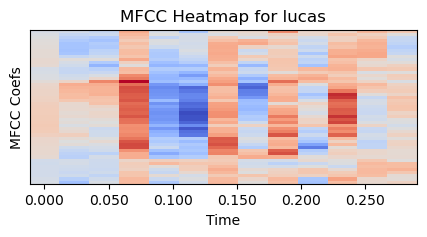

In [134]:
for i in mfccs_dictionary.keys():
    mfcc_to_show  = rd.choice(mfccs_dictionary[i])
    plt.figure(figsize=(5, 2))
    lb.display.specshow(mfcc_to_show, x_axis='time')
    plt.title("MFCC Heatmap for {}".format(i))
    plt.ylabel('MFCC Coefs')
    plt.show()

In [135]:
hmm_models = []
test_index = {}
for i in mfccs_dictionary.keys():
    model_i= hmm.GaussianHMM(n_components=len(mfccs_dictionary.keys()), covariance_type='diag')
    train , test = get_train_test(mfccs_dictionary[i])
    test_index[i] = test 
    x = np.concatenate([mfccs_dictionary[i][j] for j in train])
    model_i.fit(x)
    hmm_models.append(model_i)

In [136]:
def test_model(model_list,test_data):
    result = None
    max_score = -np.inf
    for i in range(len(mfccs_dictionary.keys())):
        curr_score = model_list[i].score(test_data)
        if( curr_score > max_score ): 
            max_score = curr_score
            result = i
    return list(mfccs_dictionary.keys())[result]
class Test_result: 
    def __init__(self, actual_value , test_result):
        self.actual_value = actual_value
        self.test_result = test_result
test_list = []
recall  ={}
precision= {}

In [138]:
for i in mfccs_dictionary.keys():
    score = 0 
    for j in test_index[i]:
        predicted_digit = test_model(hmm_models , mfccs_dictionary[i][j])
        # print("\t" + predicted_digit)
        test_list.append(Test_result(i, predicted_digit))
        if(predicted_digit == i):
            score +=1
    recall[i] = score/len(test_index[i])

In [139]:
print("Accuracy is: {}".format(sum([x for x in recall.values()])/len( mfccs_dictionary.keys())))
for i in (mfccs_dictionary.keys()):
    print("Recall for {} is: {}".format(i, recall[i]))
for i in (mfccs_dictionary.keys()):
    precision[i] = calculate_precision(test_list , i)
    print("Precision for {} is : {}".format(i , precision[i]))
for i in (mfccs_dictionary.keys()):
    print("F1 score for {} is : {}".format(i , calculate_f1(i)))

Accuracy is: 0.9216666666666667
Recall for george is: 1.0
Recall for theo is: 0.86
Recall for yweweler is: 0.98
Recall for nicolas is: 0.88
Recall for jackson is: 0.81
Recall for lucas is: 1.0
Precision for george is : 0.9900990099009901
Precision for theo is : 0.7889908256880734
Precision for yweweler is : 0.8521739130434782
Precision for nicolas is : 1.0
Precision for jackson is : 0.9418604651162791
Precision for lucas is : 0.9900990099009901
F1 score for george is : 0.9950248756218906
F1 score for theo is : 0.8229665071770336
F1 score for yweweler is : 0.9116279069767441
F1 score for nicolas is : 0.9361702127659575
F1 score for jackson is : 0.8709677419354839
F1 score for lucas is : 0.9950248756218906


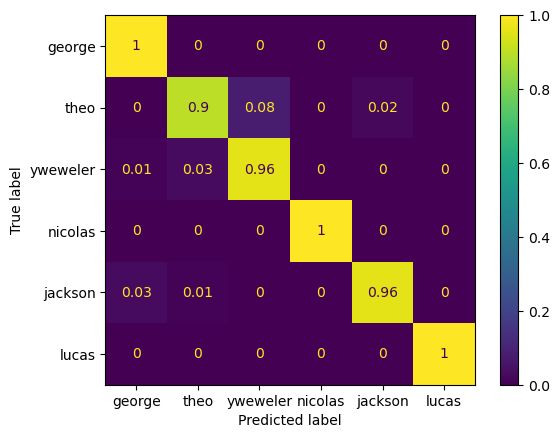

In [91]:
numbers= [x for x in mfccs_dictionary.keys()]
def calculate_confusion_matrix(test_result_list):
    matrix = [[0 for i in range(len(mfccs_dictionary.keys())) ] for i in range(len(mfccs_dictionary.keys()))]
    for i in range(6):
        for j in range(6):
           matrix[i][j]=  sum([1 for x in test_result_list if x.actual_value == list(mfccs_dictionary.keys())[i] and x.test_result==list(mfccs_dictionary.keys())[j]])/len(test_index[list(mfccs_dictionary.keys())[i]])
    return matrix

ConfusionMatrixDisplay(np.array(calculate_confusion_matrix(test_list)), display_labels=numbers).plot()
plt.show()

In [145]:
hmm_models = []
names = list(mfccs_dictionary.keys())
print(len(names))
for i in names: 
    new_hmm_model = HMM(6)
    train , test = get_train_test(mfccs_dictionary[i])
    test_index[i] = test 
    x = np.concatenate([mfccs_dictionary[i][j] for j in train])
    new_hmm_model.train(x.T/np.amax(x.T) , 2)
    hmm_models.append(new_hmm_model)

6


In [146]:
test_list = []
def test_model2(model_list,test_data):
    result = None
    max_score = -np.inf
    for i in range(6):
        curr_score = model_list[i].score(test_data.T/np.amax(test_data.T))
        if( curr_score > max_score ): 
            max_score = curr_score
            result = i
    return names[result]
for i in names: 
    score = 0 
    for j in test_index[i]:
        predicted_digit = test_model2(hmm_models , mfccs_dictionary[i][j])
        test_list.append(Test_result(i, predicted_digit))
        if(predicted_digit == i):
            score +=1
    recall[i] = score/len(test_index[i])

In [147]:
print("Accuracy is: {}".format(sum([x for x in recall.values()])/len( mfccs_dictionary.keys())))
for i in (mfccs_dictionary.keys()):
    print("Recall for {} is: {}".format(i, recall[i]))
for i in (mfccs_dictionary.keys()):
    precision[i] = calculate_precision(test_list , i)
    print("Precision for {} is : {}".format(i , precision[i]))
for i in (mfccs_dictionary.keys()):
    print("F1 score for {} is : {}".format(i , calculate_f1(i)))

Accuracy is: 0.695
Recall for george is: 0.77
Recall for theo is: 0.61
Recall for yweweler is: 0.47
Recall for nicolas is: 0.97
Recall for jackson is: 0.46
Recall for lucas is: 0.89
Precision for george is : 0.6111111111111112
Precision for theo is : 0.7176470588235294
Precision for yweweler is : 0.6351351351351351
Precision for nicolas is : 0.5511363636363636
Precision for jackson is : 0.92
Precision for lucas is : 1.0
F1 score for george is : 0.6814159292035399
F1 score for theo is : 0.6594594594594595
F1 score for yweweler is : 0.5402298850574712
F1 score for nicolas is : 0.7028985507246377
F1 score for jackson is : 0.6133333333333333
F1 score for lucas is : 0.9417989417989417


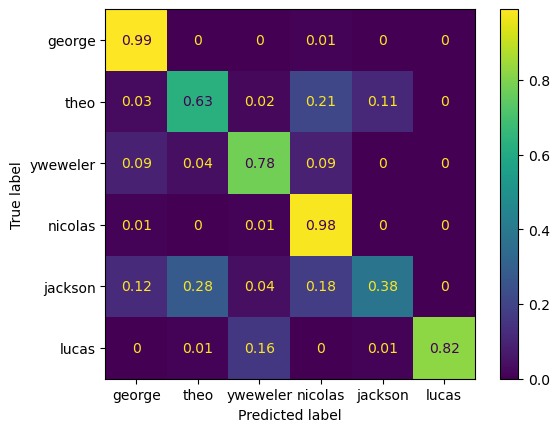

In [114]:
numbers= [x for x in mfccs_dictionary.keys()]
def calculate_confusion_matrix(test_result_list):
    matrix = [[0 for i in range(len(mfccs_dictionary.keys())) ] for i in range(len(mfccs_dictionary.keys()))]
    for i in range(6):
        for j in range(6):
           matrix[i][j]=  sum([1 for x in test_result_list if x.actual_value == list(mfccs_dictionary.keys())[i] and x.test_result==list(mfccs_dictionary.keys())[j]])/len(test_index[list(mfccs_dictionary.keys())[i]])
    return matrix

ConfusionMatrixDisplay(np.array(calculate_confusion_matrix(test_list)), display_labels=numbers).plot()
plt.show()

# Questions

## Pre-Process 

### 1. 
1. No. voices are too short and in pre-processing empty part of them was removed. So they cant be smaller any more

### 2. 
1. MFCC is standing for Mel-frequency cepstral coefficients. They are derived from a type of cepstral representation of the audio clip (a nonlinear "spectrum-of-a-spectrum")
1. Zero crossing rate the rate at which a signal changes from positive to zero to negative or from negative to zero to positive
1. A mel spectrogram is a variation of the spectrogram that is commonly used in speech processing and machine learning tasks. It is similar to a spectrogram in that it shows the frequency content of an audio signal over time, but on a different frequency axis.
1. The chroma feature is a descriptor, which represents the tonal content of a musical audio signal in a condensed form.
### 3.
1. Robustness: MFCCs are robust features that are resilient to noise, environmental conditions, and other non-informative variations in the voice signal. This is because the MFCC algorithm is designed to mimic the human auditory system’s response to sound, giving it the ability to capture essential aspects of the voice signal while discarding irrelevant details.

1. Sensitivity: While MFCCs are generally robust to minor variations, they can still be sensitive to significant changes in the voice signal, such as changes in speaker characteristics, speech style, or language. In such cases, the extracted MFCCs may not accurately represent the underlying characteristics of the voice signal, leading to potential degradation in performance for tasks like speech recognition or speaker identification.


### 4.
Here are some problems where MFCCs may not be the best choice:
1. Non-speech audio processing: MFCCs are specifically designed for capturing speech-related features and may not perform well in tasks involving non-speech audio signals such as music or environmental sounds. In such cases, other feature extraction techniques tailored for specific types of audio signals may be more appropriate.

1. Speaker recognition in noisy environments: While MFCCs are robust to some extent against noise, they may still struggle in highly noisy environments where the signal-to-noise ratio is very low. In such scenarios, other feature extraction methods that are more robust to noise or noise reduction techniques may be more suitable.

1. Emotion recognition: MFCCs may not be sufficient for accurately capturing emotional content in speech signals as they primarily focus on acoustic features related to speech production. Emotion recognition tasks may require additional features related to prosody, intonation, or other emotional cues that are not adequately captured by MFCCs alone.

1. Cross-lingual speech processing: MFCCs are sensitive to language-specific characteristics of speech signals, which can limit their effectiveness in tasks involving multiple languages or dialects. Cross-lingual speech processing may require language-agnostic features or features that can adapt to different linguistic contexts.

### 5. 
1. If you don't overlap, then events near or at the boundaries will be severely degraded, and the probability of transients (such a consonants) being between windows, or not being isolated in a single window, is increased, thus reducing how well the MFCC can categorize different inputs.
### 6. 
1. The reason why we typically consider only the first 13 MFCCs is that they capture the most relevant information for speech recognition while discarding redundant information. Higher-order coefficients contain less discriminatory information and are more sensitive to noise

## Introduction to HMM

### 1. 
1. States are what we are looking to find from our environment and later decisions are depended to this classification
1. Observations are what we comprehend from our environment and usually the observation is not completely matches to the corresponding state
1. In this problem MFCCs (the voice signal) are our observations and the target variable (the speaker or the number) is hidden state 

### 2. 
1. It is First-Order because probability of an observation at the particular time t its only depends on the immediate preceding one
1. The difference between each category is in the previous states that it depends on. for example in a second-order model the probability depends on two last states.

### 3. 
1. Hidden Markov Model is good for sequential circumstance because of its transition nature for example: Hand Writing recognition, Speech Recognition, and etc. Also it is good for uncertainty environment because of its probability nature. It could give a predict or estimate of a state based on incomplete observation.


### 4.
1. pros:  <br>
- Strong statistical foundation <br>
- Efficient learning algorithms-learning can take place directly from raw sequence data. <br>
- Allow consistent treatment of insertion and deletion penalties <br>
- in the form of locally learnable <br>
- Can handle inputs of variable length-they are the most <br>
- flexible generalization of sequence profiles. <br>
- Wide variety of applications including multiple alignment, <br>
- data mining and classification, structural analysis, and pattern <br>
- discovery. <br>
- Can be combined into libraries. <br>
2. cons :  <br>
- HMMs often have a large number of unstructured parameters. <br>
- First order HMMs are limited by their first-order markov property They cannot express dependencies between hidden states. <br>
- Proteins fold into complex 3-D shapes determining their function. <br>
- The HMM is unable to capture higher order correlation among amino acids in a protein molecule. <br>
- Only a small fraction of distributions over the space of possible sequences can be represented by a reasonably constrained HMM. <br>

### 5 
1. discrete HMM: In a discrete HMM the hidden states and the observations are discrete variables. this means that the hidden states have a finite set of values and the observations also belong to a discrete set. HMMs are mostly used in applications such as part-of-speech tagging.

2. continuous HMM: In a continuous HMM the observations are continuous variables and mostly modeled by probability density functions such as Gaussian distribution. CHMMs are often used in applications involving continuous data, such as speech recognition where features are represented as continuous variables.

3. left to right HMM : In this type the model transitions from one state to the next in a fixed left to right order. this type of HMM is useful when the process has a temporal ordering and the system evolves in a sequential manner.


## Evaluation and Analysis

### 1 
1. Accuracy: Accuracy measures the overall correctness of the model predictions. it is calculated as the ratio of the number of correct predictions to the total number of data. it can be misleading when there is an imbalanced dataset.<br>
$$\ \text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}} \$$
2. Precision :  Precision measures the proportion of positive predictions made by the model that are actually correct and true. it is calculated as the ratio of true positives to the sum of true positives and false positives. precision is useful when the cost of false positives is high.
$$ \text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}} $$
3. Recall : Recall measures the proportion of actual positive instances that are correctly identified by the model. it is calculated as the ratio of true positives to the sum of true positives and false negatives . a high recall indicates that the model is good at guessing positive datas and has a low rate of false negatives.
$$ \text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}} $$
4. F1 score: The f1 score is a harmonic mean of precision and recall providing a metric that balances both of them. it is useful when there is an imbalance between the positive and negative dataclasses.
$$ \text{F1 score} = \frac{2 \times (\text{Precision} \times \text{Recall})}{\text{Precision} + \text{Recall}} $$


### 2

- F1 Score:

Imbalanced Classes: F1 score can be affected by class imbalances, where some classes have significantly fewer instances than others. Calculating a single F1 score for all classes may not accurately reflect the performance of the classifier for each class.
Class Hierarchies: In cases where classes have hierarchical relationships, computing a single F1 score may not capture the nuances of performance at different levels of the hierarchy.

- Precision:

Multi-class Confusion: Precision may be challenging to interpret in multi-class settings when focusing on individual classes. It becomes more complex to calculate and interpret precision for each class separately, especially in the presence of imbalanced classes.

- Accuracy:

Class Imbalance: Accuracy can be misleading in the presence of class imbalances, as a high accuracy score may not accurately reflect the performance of the classifier, especially if certain classes dominate the dataset.
Equal Importance: Accuracy treats all classes equally, which may not be suitable for scenarios where some classes are more important than others.

- Recall:

Miscalculated Recall: In multi-class settings, calculating recall for each class can be more challenging due to the need to consider true positives, false negatives, and other parameters specific to each class.

### 3 
F1 score, precision, accuracy, and recall are commonly used metrics to evaluate the performance of a classification model. Here’s how each of these metrics evaluates the model:

Accuracy:

Definition: Accuracy measures the proportion of correctly classified instances (both true positives and true negatives) out of the total instances.
Evaluation: Accuracy is a straightforward metric that provides an overall assessment of the model’s performance. However, it may not be suitable for imbalanced datasets where one class dominates the others.
Precision:

Definition: Precision calculates the ratio of correctly predicted positive instances (true positives) to the total instances predicted as positive (true positives + false positives).
Evaluation: Precision is useful for assessing the model’s ability to avoid false positives. It indicates how reliable the positive predictions are.
Recall (Sensitivity):

Definition: Recall measures the ratio of correctly predicted positive instances (true positives) to the total actual positive instances (true positives + false negatives).
Evaluation: Recall is helpful for evaluating the model’s ability to capture all positive instances in the dataset. It focuses on minimizing false negatives.
F1 Score:

Definition: The F1 score is the harmonic mean of precision and recall, providing a balance between the two metrics.
Evaluation: The F1 score is useful when there is an uneven class distribution, as it considers both false positives and false negatives. A high F1 score indicates a good balance between precision and recall.

### 4

The difference between Recall and Precision is in their focus on different aspects of model performance.<br>
Recall measures how well the model identifies the true positive datas.<br>
Precision shows the ratio of predicted positive instances that are actually correct.<br>
it is important to use both Recall and Precision together because they give us complementary information. on a specific problem and its requirements a high value for one of tham may not show a good model.<br><br>
- high Percision example : imgine a case that out of 100 patients that we have their records 10 of them are actually healthy. if we design an algorithm that only returns true the Percision score would be 90%.<br>

- high Recall example : imgine a case that out of 1000 emails that we have only 10 of them are actually spam. if we design an algorithm that only returns true the Recall score would be 100%.<br>

### 5
It uses harmonic mean. the difference is the normal mean is sensitive to extreme values and is good for data that has been distributed symmetric while the harmonic mean is less sensitive to extreme values and is appropriate for skewed distributions or with rates and ratios.<br>
the harmonic mean in the F1 score is used to counter the impact of imbalanced data distributions.

### 6 & 7
 the result are upp after each part 


###  8 
the difference is obvious when you want recognize what has been told; you should classify based on frequency changes , but when you want to want recognize the speaker you need to find tone of voice